In [1]:
# Imports, settings and dataset view
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from collections import Counter
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pickle

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

In [2]:
# Global settings for dataset choosing
dataset = ["binaryAllNaturalPlusNormalVsAttacks", "multiclass", "triple"]
number = [n for n in range(1, 15)]
index = 0
model_list = []
rfecv_list = []
result_list = []
parameter=[]

In [8]:
number = [n for n in range(1, 16)]

In [3]:
def vectorize_df(df):
    df_numeric = df.select_dtypes(include=[np.number])
    # Perform label encoder on marked column
    df['marker'] = le.fit_transform(df['marker'])
    for column in df_numeric.columns:
        if column == 'marker':
            continue
        column_data = df_numeric[column]
        # To avoid Input X contains infinity or a value too large for dtype('float64') error we replace them with float.max
        column_data = column_data.replace([np.inf, -np.inf], np.finfo(np.float64).max)
        # Check if the data is normally distributed
        if column_data.skew() < 0.5:
            df_numeric[column] = ss.fit_transform(column_data.values.reshape(-1,1))
        # Check if the data has extreme outliers
        elif column_data.quantile(0.25) < -3 or column_data.quantile(0.75) > 3:
            df_numeric[column] = rs.fit_transform(column_data.values.reshape(-1,1))
        # Check if the data has a Gaussian-like distribution
        elif 0.5 < column_data.skew() < 1:
            df_numeric[column] = lt.fit_transform(column_data.values.reshape(-1,1))
        # Check if the data can be transformed into a Gaussian-like distribution
        elif column_data.skew() > 1:
            df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
        else:
            df_numeric[column] = mms.fit_transform(column_data.values.reshape(-1,1))
            df[df_numeric.columns] = df_numeric
    return df

def create_grid_search(model, params):
    # Create a grid search object which is used to find the best hyperparameters for the model
    from sklearn.model_selection import GridSearchCV
    return GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, verbose=3, cv=3, scoring='accuracy', return_train_score=True)

def show(model, X_test, y_test):
    # We print our results
    sns.set(rc={'figure.figsize': (15, 8)})
    predictions = model.predict(X_test)
    true_labels = y_test
    cf_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))

    # The heatmap is cool but this is the most important result
    print(model_report)
    return model_report

In [4]:
def feature_engeneering(df):
    # Features engineering
    apparent_impedance_measurements_headers_names = ['R1-PA:Z', 'R2-PA:Z', 'R3-PA:Z', 'R4-PA:Z']

    voltage_phase_angles_headers_names = ['R1-PA1:VH', 'R1-PA2:VH', 'R1-PA3:VH',
                                          'R2-PA1:VH', 'R2-PA2:VH', 'R2-PA3:VH',
                                          'R3-PA1:VH', 'R3-PA2:VH', 'R3-PA3:VH',
                                          'R4-PA1:VH', 'R4-PA2:VH', 'R4-PA3:VH']

    current_phase_angles_headers_names = ['R1-PA4:IH', 'R1-PA5:IH', 'R1-PA6:IH',
                                          'R2-PA4:IH', 'R2-PA5:IH', 'R2-PA6:IH',
                                          'R3-PA4:IH', 'R3-PA5:IH', 'R3-PA6:IH',
                                          'R4-PA4:IH', 'R4-PA5:IH', 'R4-PA6:IH']

    voltage_phase_magnitudes_headers_names = ['R1-PM1:V', 'R1-PM2:V', 'R1-PM3:V',
                                              'R2-PM1:V', 'R2-PM2:V', 'R2-PM3:V',
                                              'R3-PM1:V', 'R3-PM2:V', 'R3-PM3:V',
                                              'R4-PM1:V', 'R4-PM2:V', 'R4-PM3:V']

    current_phase_magnitudes_header_names = ['R1-PM4:I', 'R1-PM5:I', 'R1-PM6:I',
                                             'R2-PM4:I', 'R2-PM5:I', 'R2-PM6:I',
                                             'R3-PM4:I', 'R3-PM5:I', 'R3-PM6:I',
                                             'R4-PM4:I', 'R4-PM5:I', 'R4-PM6:I']

    # Apparent Impedance measurements for each relay (R1-PA:Z, R2-PA:Z, R3-PA:Z, R4-PA:Z), having values in the 4.8 to 4.9 range
    for header in apparent_impedance_measurements_headers_names:
        df[header+'_in_range(4.8-4.9)'] = np.where((df[header] >= 4.8) & (df[header] <= 4.9), 1, 0)

    # Voltage Phase Angles (PA1:VH – PA3:VH) in the 3.0 range
    for header in voltage_phase_angles_headers_names:
        df[header +'_in_range(3.0)'] = np.where(abs(df[header]-3.0) <= 0.5, 1, 0)

    # Current Phase Angles (PA4:IH – PA6:IH) in the 3.0 range
    for header in current_phase_angles_headers_names:
        df[header +'_in_range(3.0)'] = np.where(abs(df[header]-3.0) <= 0.5, 1, 0)

    # Voltage Phase Magnitudes (PM1:V – PM3:V) in the 3.0 range
    for header in voltage_phase_magnitudes_headers_names:
        df[header +'_in_range(3.0)'] = np.where(abs(df[header]-3.0) <= 0.5, 1, 0)

    # Current Phase Magnitudes (PM4:I – PM6:I) in the 3.0 range
    for header in current_phase_magnitudes_header_names:
        df[header +'_in_range(3.0)'] = np.where(abs(df[header]-3.0) <= 0.5, 1, 0)

    return df


See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.resha

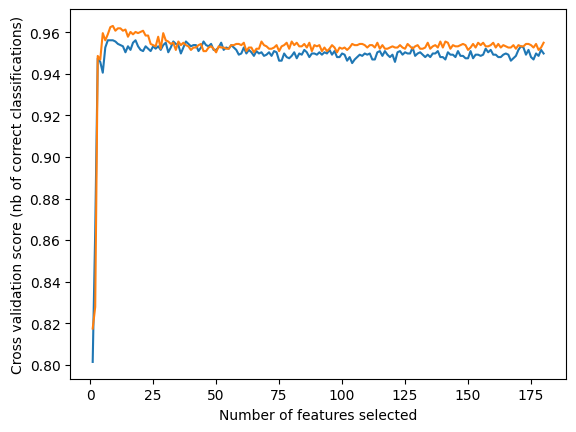

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshap

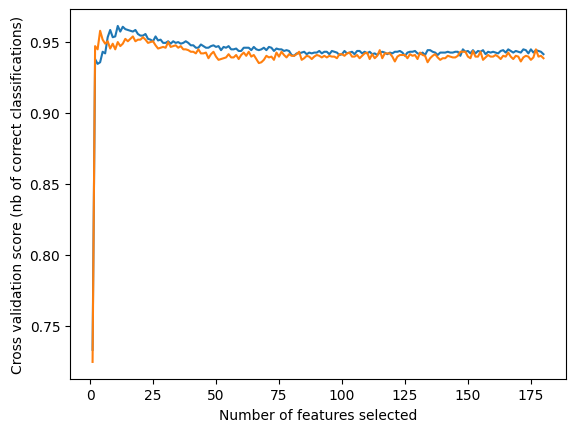

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshap

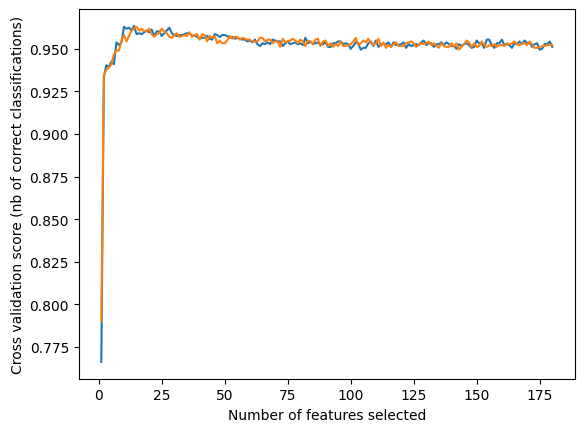

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = ss.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

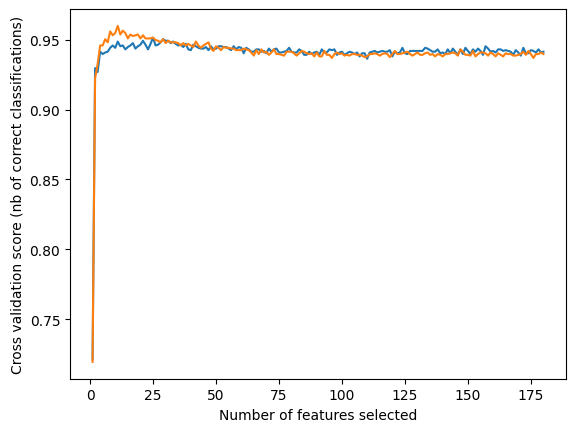

/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

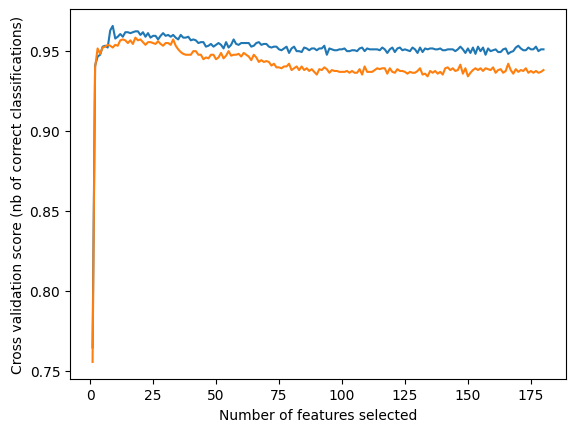


See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.resha

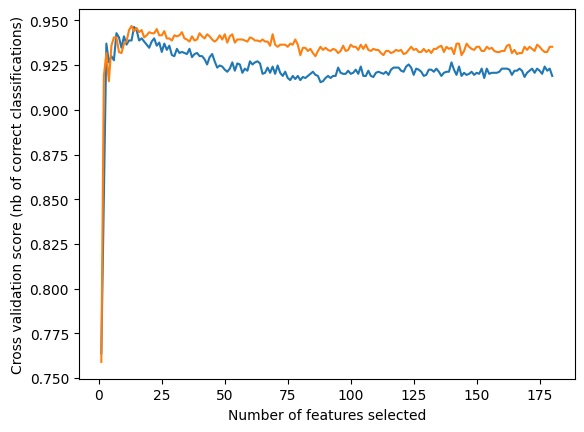

/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

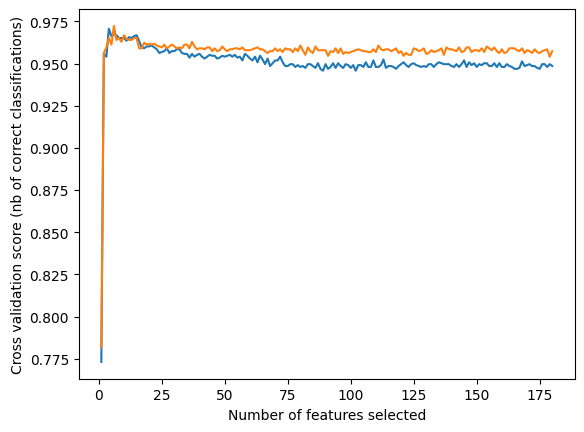

Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num

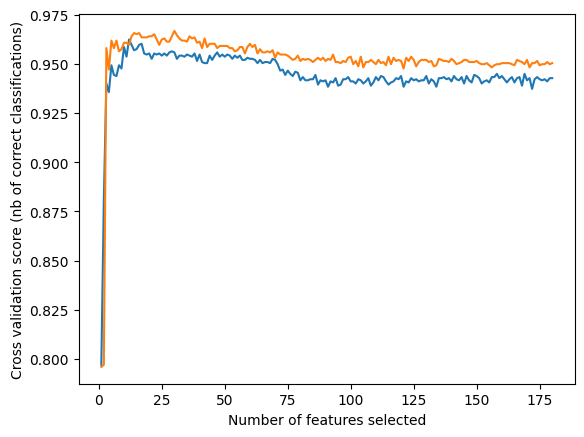

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

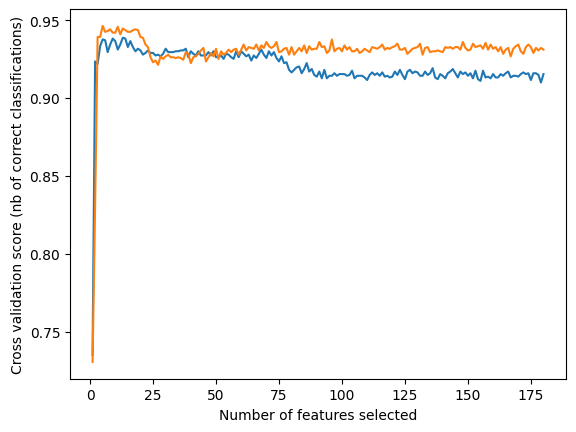

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = ss.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshap

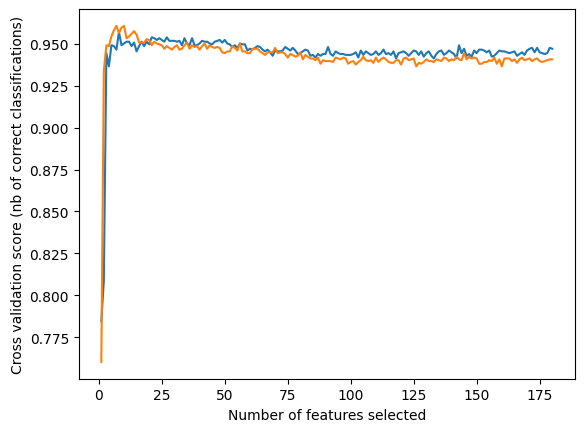

Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = ss.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num

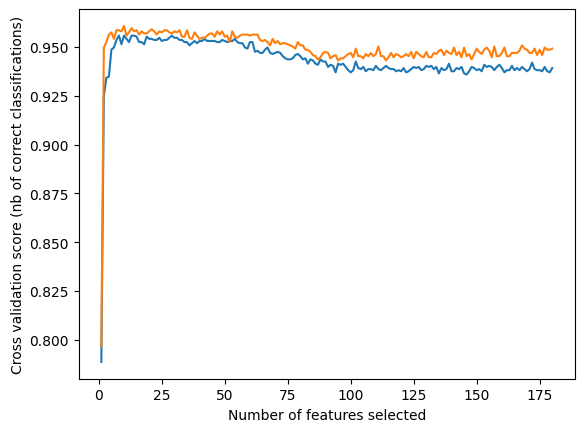

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = ss.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

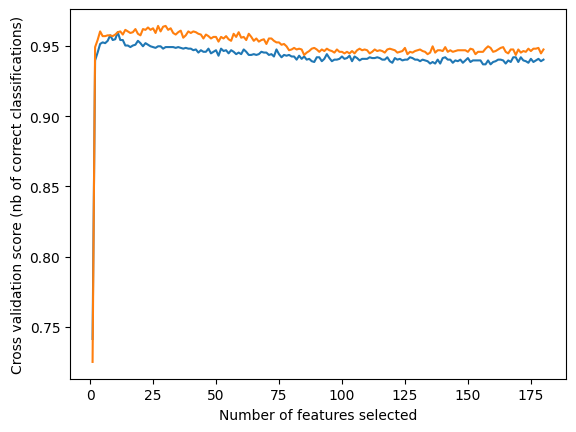

/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = ss.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

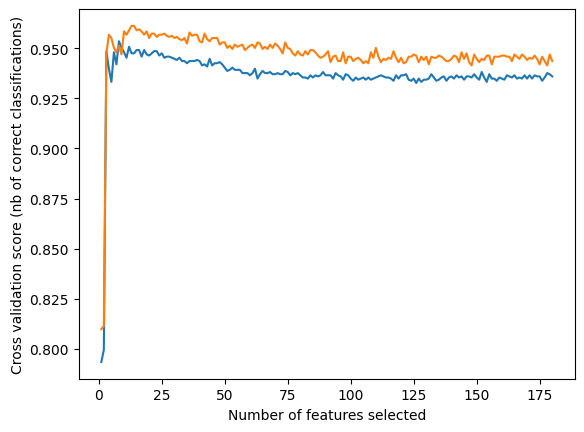

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = lt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

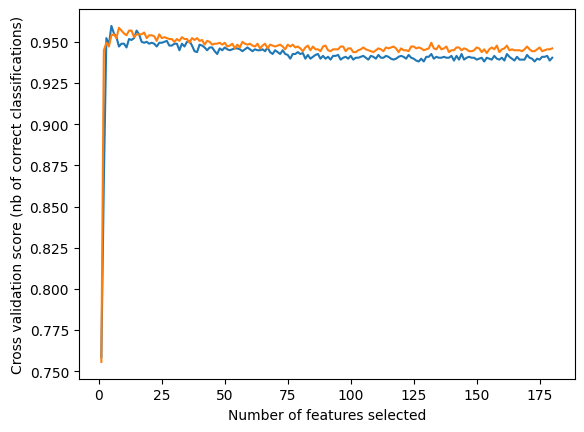

IndexError: list index out of range

In [5]:
for number_index in range(15):
    print("Currently working on "+str(dataset[index])+"/data"+str(number[number_index])+".csv")
    relevant = "./Class/"+str(dataset[index])+"/data"+str(number[number_index])+".csv"
    with open(relevant, 'rb') as file:
        df = pd.read_csv(file)

    df = feature_engeneering(df)
    
    for column in df.columns[df.isna().any()].tolist():
        df[column] = df[column].fillna(0.0)
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    df = df.reset_index()

    # LabelEncoder encodes labels with a value between 0 and n_classes-1
    le = LabelEncoder()
    # StandardScaler scales values by subtracting the mean and dividing by the standard deviation
    ss = StandardScaler()
    # QuantileTransformer transforms features using quantiles information
    qt = QuantileTransformer()
    # RobustScaler scales values by subtracting the median and dividing by the interquartile range
    rs = RobustScaler()
    # MinMaxScaler scales values between 0 and 1
    mms = MinMaxScaler()
    # LogTransformer transforms features by taking the natural logarithm
    lt = FunctionTransformer(np.log1p)
    # Preprocessing
    df = vectorize_df(df)

    # Choose features for the model
    features_list = df.columns.to_list()
    features_list.remove('marker')
    features_list.remove('index')
    
    # Train test split
    X = df[features_list]
    y = np.stack(df['marker'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    counter = Counter(y)

    # Feature selection

    from sklearn.feature_selection import RFECV
    from sklearn.model_selection import StratifiedKFold

    # Create the RFE object and compute a cross-validated score.
    # The "accuracy" scoring is proportional to the number of correct classifications
    recall_scorer = make_scorer(recall_score, pos_label=1, average='macro')
    rfecv = RFECV(estimator=RandomForestClassifier(n_estimators=750,criterion= "entropy",max_depth= 20, min_samples_split= 2, random_state=43, n_jobs = -1), step=1, cv=StratifiedKFold(2), scoring='accuracy', verbose=1, n_jobs=-1)
    #rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=StratifiedKFold(2), scoring='accuracy', verbose=1, n_jobs=-1)
    rfecv.fit(X_train, y_train)
    # Save the model
    pickle.dump(rfecv, open("1/m_"+str(number[number_index])+"rfecv.pkl", 'wb'))
    rfecv_list.append(rfecv)
    X_train = rfecv.transform(X_train)
    X_test = rfecv.transform(X_test)
    parameter.append((X_train, X_test, y_train, y_test))
        
    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

In [12]:
number_index = 15
print("Currently working on "+str(dataset[index])+"/data15.csv")
relevant = "./Class/"+str(dataset[index])+"/data15.csv"
with open(relevant, 'rb') as file:
    df = pd.read_csv(file)

df = feature_engeneering(df)
    
for column in df.columns[df.isna().any()].tolist():
    df[column] = df[column].fillna(0.0)
    
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.reset_index()

# LabelEncoder encodes labels with a value between 0 and n_classes-1
le = LabelEncoder()
# StandardScaler scales values by subtracting the mean and dividing by the standard deviation
ss = StandardScaler()
# QuantileTransformer transforms features using quantiles information
qt = QuantileTransformer()
# RobustScaler scales values by subtracting the median and dividing by the interquartile range
rs = RobustScaler()
# MinMaxScaler scales values between 0 and 1
mms = MinMaxScaler()
# LogTransformer transforms features by taking the natural logarithm
lt = FunctionTransformer(np.log1p)
# Preprocessing
df = vectorize_df(df)

# Choose features for the model
features_list = df.columns.to_list()
features_list.remove('marker')
features_list.remove('index')
    
# Train test split
X = df[features_list]
y = np.stack(df['marker'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)

# Feature selection

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
recall_scorer = make_scorer(recall_score, pos_label=1, average='macro')
rfecv = RFECV(estimator=RandomForestClassifier(n_estimators=750,criterion= "entropy",max_depth= 20, min_samples_split= 2, random_state=43, n_jobs = -1), step=1, cv=StratifiedKFold(2), scoring='accuracy', verbose=1, n_jobs=-1)
#rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=StratifiedKFold(2), scoring='accuracy', verbose=1, n_jobs=-1)
rfecv.fit(X_train, y_train)
# Save the model
pickle.dump(rfecv, open("1/m_"+str(number[number_index])+"rfecv.pkl", 'wb'))
rfecv_list.append(rfecv)
X_train = rfecv.transform(X_train)
X_test = rfecv.transform(X_test)
parameter.append((X_train, X_test, y_train, y_test))
        
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = ss.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.reshape(-1,1))
/tmp/ipykernel_97/2708712824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = qt.fit_transform(column_data.values.resha

IndexError: list index out of range

In [13]:
# Save the rfecv_list
pickle.dump(rfecv_list, open("1/rfecv_list.pkl", 'wb'))

In [18]:
def create_grid_search(model, params):
    # Create a grid search object which is used to find the best hyperparameters for the model
    from sklearn.model_selection import GridSearchCV
    return GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, verbose=3, cv=5, scoring='accuracy', return_train_score=True)

In [19]:
def show(model):
    # We print our results
    sns.set(rc={'figure.figsize': (15, 8)})
    predictions = model.predict(X_test)
    true_labels = y_test
    cf_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))

    # The heatmap is cool but this is the most important result
    print(model_report)


           0    0.95232   0.96848   0.96034       825
           1    0.93333   0.90099   0.91688       404

    accuracy                        0.94630      1229
   macro avg    0.94283   0.93474   0.93861      1229
weighted avg    0.94608   0.94630   0.94605      1229

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END algorithm=auto, leaf_size=10, n_jobs=-1, n_neighbors=3, p=1, weights=distance;, score=(train=1.000, test=0.954) total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=10, n_jobs=-1, n_neighbors=3, p=1, weights=distance;, score=(train=1.000, test=0.972) total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=10, n_jobs=-1, n_neighbors=3, p=1, weights=distance;, score=(train=1.000, test=0.967) total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=10, n_jobs=-1, n_neighbors=3, p=1, weights=distance;, score=(train=1.000, test=0.963) total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=10, n_jobs=-1, n_neighbors=3, p=1, weights=distance;,

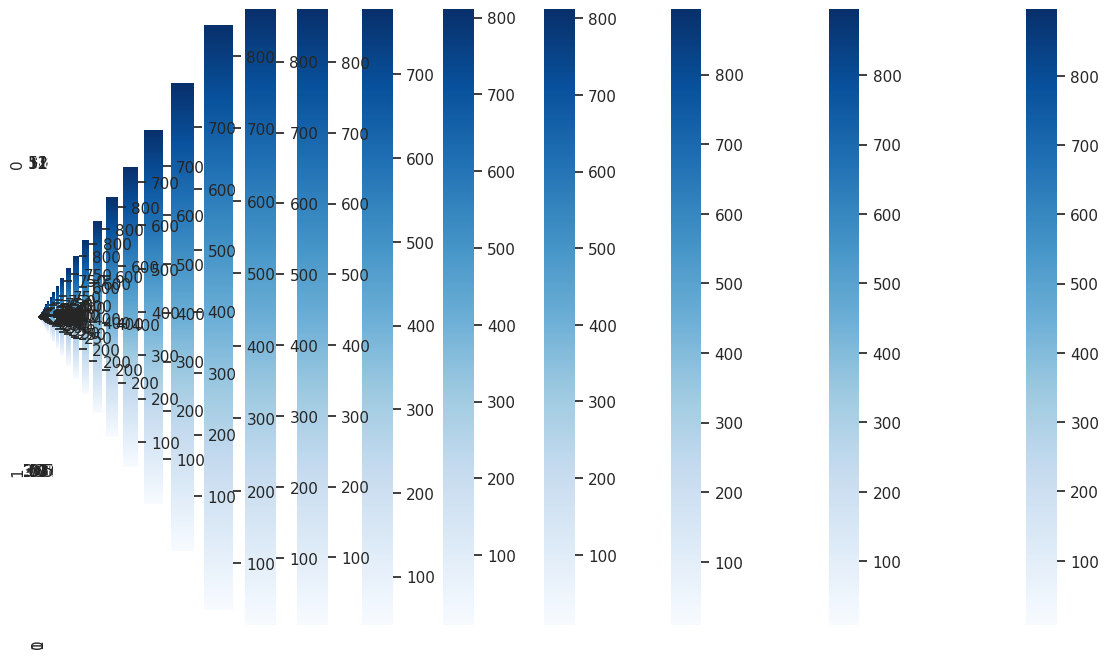

In [20]:
for number_index in range(15):
    X_train, X_test, y_train, y_test = parameter[number_index][0], parameter[number_index][1], parameter[number_index][2], parameter[number_index][3]
    # Random Forest Classifier
    rf = RandomForestClassifier()
    rf_params = {
        "n_estimators": [750],
        "criterion": ["gini", "entropy"],
        "max_depth": [20, 35, 50],
        "min_samples_split": [2,5],
        "random_state": [43],
        "n_jobs": [-1],
    }
    rf_grid = create_grid_search(rf, rf_params)
    rf_grid.fit(X_train, y_train)
    rf = rf_grid.best_estimator_
    pickle.dump(rf, open('1/rfc'+str(number_index)+'.pkl', 'wb'))
    show(rf)

    # Random Forest Classifier + AdaBoost
    rf_ada = AdaBoostClassifier(base_estimator=rf)
    rf_ada_params = {
        'n_estimators': [450, 650, 950],
        'learning_rate': [0.01, 0.1, 0.5, 1.0],
    }
    rf_ada_gcv = create_grid_search(rf_ada, rf_ada_params)
    rf_ada_gcv.fit(X_train, y_train)
    rf_ada = rf_ada_gcv.best_estimator_
    pickle.dump(rf_ada, open('1/rf_adac'+str(number_index)+'.pkl', 'wb'))
    show(rf_ada)

    # K Nearest Neighbors
    knn = KNeighborsClassifier()
    knn_params = {
        "n_neighbors": [3],
        "weights": ["distance"],
        "algorithm": ["auto"],
        "leaf_size": [10],
        "p": [1],
        "n_jobs": [-1],
    }
    knn_grid = create_grid_search(knn, knn_params)
    knn_grid.fit(X_train, y_train)
    knn = knn_grid.best_estimator_
    pickle.dump(knn, open('1/knn'+str(number_index)+'.pkl', 'wb'))
    show(knn)

    # Stacking Classifier ( Combining all the models )
    from sklearn.ensemble import StackingClassifier
    sc = StackingClassifier(estimators=[('rf', rf), ('rf_ada', rf_ada), ('knn', knn)], final_estimator=LogisticRegression())
    sc_params = {   
        'n_jobs': [-1],
    }
    sc_grid = create_grid_search(sc, sc_params)
    sc_grid.fit(X_train, y_train)
    sc = sc_grid.best_estimator_
    pickle.dump(sc, open('1/sc'+str(number_index)+'.pkl', 'wb'))

model_list.append((rf, rf_ada, knn, sc))
pickle.dump(model_list, open('1/model_list'+str(number_index)+'.pkl', 'wb'))

In [ ]:


df_1 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data12.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_1

In [ ]:


df_2 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data2.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_2

In [ ]:


df_3 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data1.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_3

In [ ]:


df_4 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data4.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_4

In [ ]:


df_5 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data15.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_5

In [ ]:


df_6 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data10.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_6

In [ ]:


df_7 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data14.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_7

In [ ]:


df_8 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data7.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_8

In [ ]:


df_9 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data11.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_9

In [ ]:


df_10 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data5.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_10

In [ ]:


df_11 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data6.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_11

In [ ]:


df_12 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data9.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_12

In [ ]:


df_13 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data13.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_13

In [ ]:


df_14 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data8.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_14

In [ ]:


df_15 = _deepnote_execute_sql("""SELECT *
FROM 'Class/binaryAllNaturalPlusNormalVsAttacks/data3.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_15

In [ ]:


df_16 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data12.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_16

In [ ]:


df_17 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data2.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_17

In [ ]:


df_18 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data1.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_18

In [ ]:


df_19 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data4.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_19

In [ ]:


df_20 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data15.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_20

In [ ]:


df_21 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data10.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_21

In [ ]:


df_22 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data14.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_22

In [ ]:


df_23 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data7.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_23

In [ ]:


df_24 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data11.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_24

In [ ]:


df_25 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data5.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_25

In [ ]:


df_26 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data6.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_26

In [ ]:


df_27 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data9.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_27

In [ ]:


df_28 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data13.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_28

In [ ]:


df_29 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data8.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_29

In [ ]:


df_30 = _deepnote_execute_sql("""SELECT *
FROM 'Class/multiclass/data3.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_30

In [ ]:


df_31 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data12.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_31

In [ ]:


df_32 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data2.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_32

In [ ]:


df_33 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data1.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_33

In [ ]:


df_34 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data4.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_34

In [ ]:


df_35 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data15.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_35

In [ ]:


df_36 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data10.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_36

In [ ]:


df_37 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data14.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_37

In [ ]:


df_38 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data7.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_38

In [ ]:


df_39 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data11.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_39

In [ ]:


df_40 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data5.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_40

In [ ]:


df_41 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data6.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_41

In [ ]:


df_42 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data9.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_42

In [ ]:


df_43 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data13.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_43

In [ ]:


df_44 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data8.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_44

In [ ]:


df_45 = _deepnote_execute_sql("""SELECT *
FROM 'Class/triple/data3.csv'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_45

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=af7c1e7b-755a-45f3-9a01-9215a58739b2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>